## Q DEMDE: Quantum-classical density matrix density estimation

## Libraries

In [1]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.8/49.8 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.5/18.5 MB 34.5 MB/s eta 0:00:00


In [2]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from pennylane.optimize import NesterovMomentumOptimizer
from scipy.stats import norm
import numpy as onp
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

## Classical Prediction with Complex Adaptive RFF

In [3]:
import pylab as pl
from sklearn.kernel_approximation import RBFSampler

def rff_map(x, gamma, n_components, random_state=0):
    rbf_feature = RBFSampler(gamma=gamma, n_components=n_components, random_state=random_state)
    return rbf_feature.fit_transform(x)

def gauss_kernel(x, y, gamma):
    return np.exp(-gamma * (x - y) ** 2)

In [4]:
class QFeatureMapCompAdaptRFF(tf.keras.layers.Layer):

    def __init__(
                 self,
                 input_dim: int,
                 dim: int = 100,
                 gamma: float = 1,
                 random_state = None,
                 gamma_trainable=False,
                 weights_trainable=True,
                 **kwargs
                 ):
        self.g_trainable = gamma_trainable
        self.w_trainable = weights_trainable
        super().__init__(**kwargs)
        self.input_dim = input_dim
        self.dim = dim
        self.gamma = gamma
        self.random_state = random_state

    def build(self, input_shape):
        rbf_sampler = RBFSampler(
            gamma=0.5,
            n_components=self.dim,
            random_state=self.random_state)
        x = np.zeros(shape=(1, self.input_dim))
        rbf_sampler.fit(x)
        self.gamma_val = tf.Variable(
            initial_value=self.gamma,
            dtype=tf.float32,
            trainable=self.g_trainable,
            name="rff_gamma")
        self.rff_weights = tf.Variable(
            initial_value=rbf_sampler.random_weights_,
            dtype=tf.float32,
            trainable=self.w_trainable,
            name="rff_weights")
        self.built = True

    def call(self, inputs):
        # Complex Adaptive RFF
        vals = tf.sqrt(self.gamma_val) * tf.matmul(inputs, self.rff_weights)
        vals = tf.complex(tf.cos(vals), -tf.sin(vals))
        vals = vals * tf.cast(tf.sqrt(1. / self.dim), tf.complex64)
        norms = tf.linalg.norm(vals, axis=-1)
        psi = vals / tf.expand_dims(norms, axis=-1)
        return psi


class DMRFF(tf.keras.Model):
    def __init__(self,
                 dim_x,
                 num_rff,
                 gamma=1,
                 random_state=None):
        super().__init__()
        self.rff_layer = QFeatureMapCompAdaptRFF(input_dim=dim_x, dim=num_rff, gamma=gamma, random_state=random_state, gamma_trainable=False)

    def call(self, inputs):

        # Complex Adaptive RFF
        x1 = inputs[:, 0]
        x2 = inputs[:, 1]
        phi1 = self.rff_layer(x1)
        phi2 = self.rff_layer(x2)
        dot = tf.einsum('...i,...i->...', tf.math.conj(phi1), phi2) * tf.einsum('...i,...i->...', tf.math.conj(phi2), phi1)
        dot = tf.cast(dot, tf.float32)
        return dot

def calc_rbf(dmrff, x1, x2):
    return dmrff.predict(np.concatenate([x1[:, np.newaxis, ...],
                                         x2[:, np.newaxis, ...]],
                                        axis=1),
                         batch_size=256)

# 2 Dimensions

In [5]:
def calculate_constant_qmkde(gamma=1, dimension = 1):
  sigma = (4*gamma)**(-1/2)
  coefficient = 1 /  (2*np.pi*sigma**2)**(dimension/2)
  return coefficient

In [6]:
def calculate_constant_log_qmkde(gamma=1, dimension = 1):
  sigma = (4*gamma)**(-1/2)
  coefficient = np.log(1) - (dimension/2.) *   np.log(2*np.pi*sigma**2)
  return coefficient

In [7]:
def raw_kde(x_test, x_train, gamma=1):
  sigma = (2*gamma)**(-1/2)
  euclidean_distance = np.sum(((x_test-x_train))**2, axis=1)
  exponential  = np.exp(-euclidean_distance/(2*sigma**2))
  constant_outside = 1/(np.size(x_train) * (2*np.pi*sigma**2)**(x_train.shape[1]/2))
  return constant_outside * np.sum(exponential)

In [8]:
def raw_log_kde(x_test, x_train, gamma=1):
  sigma = (2*gamma)**(-1/2)
  euclidean_distance = np.sum(((x_test-x_train))**2, axis=1)
  exponential  = np.exp(-euclidean_distance/(2*sigma**2))
  constant_outside = np.log(1) - np.log(np.size(x_train)) - (x_train.shape[1]/2) * np.log(2*np.pi*sigma**2)
  return constant_outside + np.log(np.sum(exponential))

In [9]:
def plot(X_train, X_train_density, X_test, X_test_density, name = "dataset"):
    plt.axes(frameon = 0)
    plt.grid()
    plt.scatter(X_test[:,0],  X_test[:,1], c = X_test_density , alpha = .5, s = 3, linewidths= 0.0000001)
    plt.colorbar()
    plt.title('potential 1 dataset')
    plt.savefig(f'{name}.png',dpi = 300)
    plt.show()

# ARC dataset

Weird Gaussians from `Masked Autoregressive Flow for Density Estimation`
***

See the article [here](https://arxiv.org/pdf/1705.07057.pdf) where the distribution of the data is given by the following density:

$$
p(x,y) = \mathcal{N}\left(x_2| 0,4\right) \mathcal{N}\left(x_1|\frac{1}{4}x_2^2,1\right)
$$

## Dataset Generation

In [10]:
dataset_size = 40_000

In [11]:
x2_dist = tfd.Normal(loc=0., scale=4.)
x2_samples = x2_dist.sample(dataset_size)
x1 = tfd.Normal(loc=.25 * tf.square(x2_samples),
                scale=tf.ones(dataset_size, dtype=tf.float32))
x1_samples = x1.sample()
x_samples = tf.stack([x1_samples, x2_samples], axis=1)

In [12]:
X_densities = x2_dist.prob(x_samples[:,1]) * x1.prob(x_samples[:,0])

True densities

In [13]:
x2 = tfp.distributions.Normal(loc = 0., scale = 4.)
x1 = tfp.distributions.Normal(loc = .25 * tf.square(x_samples[:,1]), scale = tf.ones(40_000, dtype=tf.float32))

In [14]:
X_densities = x2.prob(x_samples[:,1]) * x1.prob(x_samples[:,0])

Scatter plot of the data

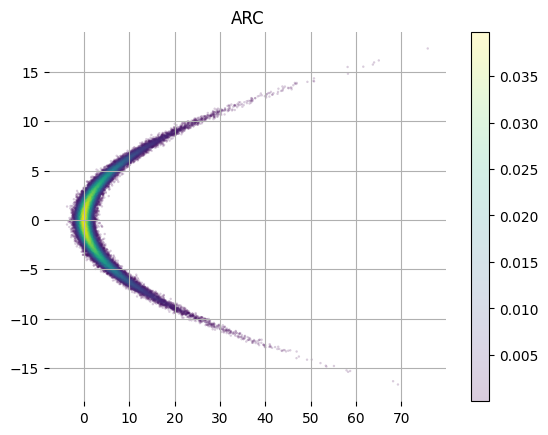

In [15]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(x_samples[:,0],  x_samples[:,1], c = X_densities.numpy() , alpha = .2, s = 3, linewidths= 0.0000001)
plt.colorbar()
plt.title('ARC')
plt.savefig('alldensities_arc.png',dpi = 300)
plt.show()

To generate mesh grid data that will be used to calculate probability density plot

In [16]:
import scipy.stats

In [17]:
x, y = onp.mgrid[-10:40:(50/120), -15:15:(30/120)]
pos = onp.dstack((x, y))
X_plot = pos.reshape([14400,2])

real_prob = x2_dist.prob(X_plot[:,1]) * scipy.stats.norm(0.25 * np.square(X_plot[:,1]), 1).pdf(X_plot[:,0])

In [18]:
plt.rcParams["figure.figsize"] = (20*0.25,15*0.25)

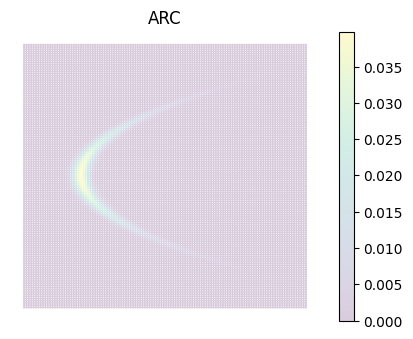

In [19]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(x, y, c = real_prob.numpy().reshape([120,120]) , alpha = .2, s = 3, linewidths= 0.0000001)
plt.colorbar()
plt.title('ARC')
plt.yticks([])
plt.xticks([])
plt.savefig('alldensities_arc.png',dpi = 300)
plt.show()

In [20]:
x_samples.shape

TensorShape([40000, 2])

In [21]:
from  sklearn import model_selection
batch_size = 32
train_set, test_set = model_selection.train_test_split(x_samples.numpy(), test_size=0.3)

train_dataset = tf.data.Dataset.from_tensor_slices(train_set)
batched_train_data = train_dataset.batch(batch_size)

# Kernel density estimation baseline

In [22]:
gamma = 2
raw_kde_probability = onp.array([raw_kde(x_temp[np.newaxis,:], train_set, gamma) for x_temp in X_plot])

In [23]:
(1 / real_prob.shape[0]) * onp.sum(onp.abs(real_prob - raw_kde_probability))

0.0003864646620220608

max probability: 0.017156897354060126
min probability: 4.240753849626912e-199
log max probability: -4.065355008142807
log min probability: -456.7696924576515


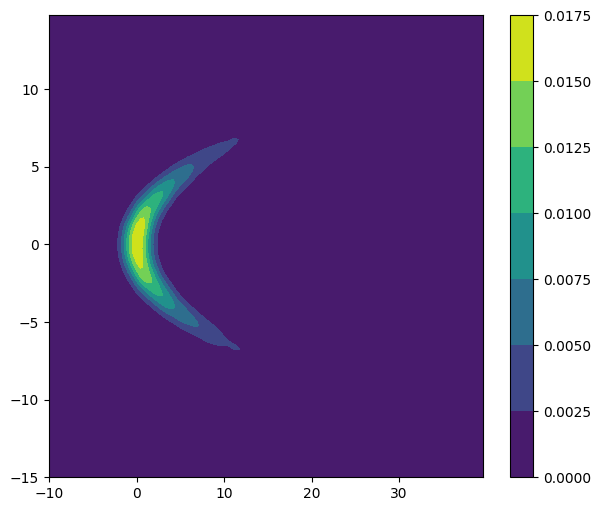

In [24]:
params = {
   'axes.labelsize': 12,
   'legend.fontsize': 12,
   'xtick.labelsize': 10,
   'ytick.labelsize': 10,
   'text.usetex': False,
   'figure.figsize': [7.0, 6.0]
   }
plt.rcParams.update(params)

print("max probability:", raw_kde_probability.max())
print("min probability:",raw_kde_probability.min())

print("log max probability:", np.log(raw_kde_probability.max()))
print("log min probability:", np.log(raw_kde_probability.min()))

plt.contourf(x, y, raw_kde_probability.reshape([120,120]))
plt.colorbar()
plt.savefig("arcdsdmkde.pdf")

# Q-DEMDE method

In [107]:
sigma_kernel_training = 1
gamma_kernel_training = 1/(2*sigma_kernel_training**2)

print(sigma_kernel_training, gamma_kernel_training)

1 0.5


In [108]:
### training with gaussian training data set
def gaussian_kernel_data(dim_x_param, size_data_param, gamma_train_param = 0.5):
  X_3_temp = np.random.multivariate_normal(mean = np.zeros(2), cov = (1/(2*gamma_train_param*dim_x_param))*np.identity(dim_x_param), size = size_data_param)
  X_4_temp = np.zeros((40_000, 2))
  return X_3_temp, X_4_temp

X_3, X_4 = gaussian_kernel_data(2, 40000)

X_3.shape, X_4.shape

((40000, 2), (40000, 2))

In [109]:
n_rffs = 16
dmrff = DMRFF(dim_x=2, num_rff=n_rffs, gamma=gamma_kernel_training, random_state=15)
dmrff.predict(np.concatenate([X_3[:, np.newaxis, ...],
                                         X_4[:, np.newaxis, ...]],
                                        axis=1),
                         batch_size=256)

157/157 [==============================] - 0s 2ms/step


array([0.4759688 , 0.7868149 , 0.3665289 , ..., 0.9494462 , 0.45847222,
       0.3412906 ], dtype=float32)

In [110]:
print(f'Weights: {dmrff.rff_layer.rff_weights}')

Weights: <tf.Variable 'dmrff_4/q_feature_map_comp_adapt_rff_4/rff_weights:0' shape=(2, 16) dtype=float32, numpy=
array([[-0.3123285 ,  0.33928472, -0.15590854, -0.5017897 ,  0.2355689 ,
        -1.7636052 , -1.095862  , -1.0877657 , -0.30517006, -0.4737484 ,
        -0.20059454,  0.35519677,  0.68951774,  0.41058967, -0.5649784 ,
         0.5993907 ],
       [-0.1629363 ,  1.6002145 ,  0.6816272 ,  0.0148801 , -0.08777963,
        -0.98211783,  0.12169048, -1.1374373 ,  0.34900257, -1.8585131 ,
        -1.1671818 ,  1.4248968 ,  1.4965653 ,  1.289932  , -1.8117453 ,
        -1.4983072 ]], dtype=float32)>


In [111]:
weights_qrff = dmrff.rff_layer.rff_weights.numpy()

weights_qrff.mean(), weights_qrff.std()

(-0.17373163, 0.9455772)

In [112]:
def gauss_kernel_arr(x, y, gamma_param):
    return onp.exp(-gamma_param * onp.linalg.norm(x - y, axis=1) ** 2)

num_samples = 60_000 # num_samples original = 10000
rnd_idx1 = onp.random.randint(X_3.shape[0],size=(num_samples, ))
rnd_idx2 = onp.random.randint(X_4.shape[0],size=(num_samples, ))
x_train = onp.concatenate([X_3[rnd_idx1][:, onp.newaxis, ...],
                          X_4[rnd_idx2][:, onp.newaxis, ...]],
                         axis=1)

y_train = gauss_kernel_arr(x_train[:, 0, ...], x_train[:, 1, ...], gamma_param=gamma_kernel_training)

x_train.shape, y_train.shape

((60000, 2, 2), (60000,))

In [113]:
epochs = 2
opt = keras.optimizers.Adam(learning_rate=0.001)
dmrff.compile(optimizer=opt, loss="mse")
dmrff.fit(x_train, y_train, batch_size = 5, epochs=epochs)

Epoch 1/2


12000/12000 [==============================] - 26s 2ms/step - loss: 5.1369e-04
Epoch 2/2
12000/12000 [==============================] - 25s 2ms/step - loss: 2.0246e-06


In [114]:
print(f'Weights: {dmrff.rff_layer.rff_weights}')

Weights: <tf.Variable 'dmrff_4/q_feature_map_comp_adapt_rff_4/rff_weights:0' shape=(2, 16) dtype=float32, numpy=
array([[-0.569305  , -0.3433369 , -0.31549317, -0.72607255,  0.85154647,
        -2.5360482 , -1.4064528 , -1.2049029 , -0.4180067 , -0.55191123,
         0.56638855,  0.08291645,  1.2989603 ,  0.6713245 , -0.6254895 ,
         1.3688862 ],
       [-0.05604427,  1.949814  ,  0.05529084,  0.1060679 , -0.44210568,
        -0.375105  ,  0.8151098 , -0.7672116 , -0.03516449, -1.7303989 ,
        -0.6203068 ,  0.48254701,  1.3401875 , -0.01020445, -1.527573  ,
        -1.7596936 ]], dtype=float32)>


In [115]:
weights_qaff = dmrff.rff_layer.rff_weights.numpy()

weights_qaff.mean(), weights_qaff.std()

(-0.20099336, 0.9971891)

## Q-DEMDE QRFF

In [116]:
## Make predictions
# 16 features

gamma_feat = 2.0

weights_rff_temp = weights_qrff

def predict_features(X, var2, gamma_param):
  X_feat = onp.ones((len(X), var2.shape[1]), dtype = onp.complex128)
  X_feat[:, :] = onp.cos(np.sqrt(gamma_param)*(X @ var2)) - 1j*onp.sin(np.sqrt(gamma_param)*(X @ var2))
  X_feat *= onp.sqrt(1/(var2.shape[1]))
  return X_feat

X_feat_train = predict_features(train_set, weights_rff_temp, gamma_feat)
X_feat_test = predict_features(X_plot, weights_rff_temp, gamma_feat)

X_feat_train.shape, X_feat_test.shape

((28000, 16), (14400, 16))

In [117]:
## Training
rho_train = onp.zeros((n_rffs, n_rffs))

for i in range(len(X_feat_train)):
  rho_train = rho_train + onp.outer(X_feat_train[i], onp.conjugate(X_feat_train[i]))

rho_train = rho_train / len(X_feat_train)

(onp.abs(X_feat_train[0])**2).sum()

1.0000000034098266

### QDMKDE circuit

In [118]:
num_qubits_temp = 2*int(np.log2(n_rffs))

dev_dmkde = qml.device("lightning.qubit", wires = 2*num_qubits_temp)

@qml.qnode(dev_dmkde)
def QDMKDE(x_test, U_train, lambda_train):
    upper_wires = [i for i in range(int(num_qubits_temp/2))]
    lower_wires = [i for i in range(int(num_qubits_temp/2), int(num_qubits_temp))]
    qml.MottonenStatePreparation(state_vector=x_test, wires=upper_wires)
    qml.MottonenStatePreparation(state_vector=np.sqrt(lambda_train), wires=lower_wires)
    qml.QubitUnitary(np.conjugate(U_train.T), wires=upper_wires)
    for i in range(int(num_qubits_temp//2)):
      qml.CNOT([lower_wires[i], upper_wires[i]])

    return qml.probs(wires=upper_wires)



In [119]:
## Predicting the density

lambda_train, U_train = np.linalg.eigh(rho_train)
prob_expected_mixed = onp.zeros(len(X_feat_test))

for i in range(len(prob_expected_mixed)):
  prob_expected_mixed[i] = QDMKDE(X_feat_test[i], U_train, lambda_train)[0]

prob_expected_mixed = calculate_constant_qmkde(gamma_feat/2, 2)*prob_expected_mixed


prob_expected_mixed.shape

(14400,)

max probability: 0.08647314332592641
min probability: 0.021680003670574106
log max probability: -2.4479213950349483
log min probability: -3.831364933103782


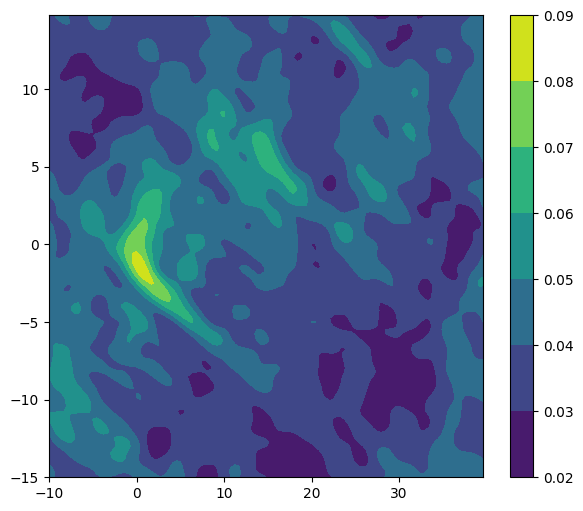

In [120]:
params = {
   'axes.labelsize': 12,
   'legend.fontsize': 12,
   'xtick.labelsize': 10,
   'ytick.labelsize': 10,
   'text.usetex': False,
   'figure.figsize': [7.0, 6.0]
   }
plt.rcParams.update(params)

print("max probability:", prob_expected_mixed.max())
print("min probability:",prob_expected_mixed.min())

print("log max probability:", np.log(prob_expected_mixed.max()))
print("log min probability:", np.log(prob_expected_mixed.min()))

#plt.contourf(x, y, prob_expected_mixed2_rff.reshape([120,120]))
plt.contourf(x, y, prob_expected_mixed.reshape([120,120]))
plt.colorbar()
plt.savefig("arcdmkde.pdf")

### Metrics

In [121]:
## K-L Divergence
from scipy.stats import entropy

# Compute KL Divergence
kl_divergence = entropy(raw_kde_probability, prob_expected_mixed)

print("KL Divergence:", kl_divergence)


KL Divergence: 2.3561380453095975


In [122]:
from scipy.stats import spearmanr

# Calculate the ranks of the density values
ranks1 = np.array(raw_kde_probability).argsort().argsort()
ranks2 = prob_expected_mixed.argsort().argsort()

# Calculate the Spearman correlation
spearman_corr, _ = spearmanr(ranks1, ranks2)

print("Spearman Correlation:", spearman_corr)

Spearman Correlation: 0.20839064324551818


In [123]:
# Calculate the absolute differences at each evaluation point
absolute_differences = np.abs(raw_kde_probability - prob_expected_mixed)

# Average the absolute differences
average_error = np.mean(absolute_differences)

print("Mean Average Error:", average_error)

Mean Average Error: 0.03909759228137576


## Q-DEMDE QAFF

In [124]:
## Make predictions
# 16 features

gamma_feat = 2.0

weights_qaff_temp = weights_qaff

def predict_features(X, var2, gamma_param):
  X_feat = onp.ones((len(X), var2.shape[1]), dtype = onp.complex128)
  X_feat[:, :] = onp.cos(np.sqrt(gamma_param)*(X @ var2)) - 1j*onp.sin(np.sqrt(gamma_param)*(X @ var2))
  X_feat *= onp.sqrt(1/(var2.shape[1]))
  return X_feat


X_feat_train = predict_features(train_set, weights_qaff_temp, gamma_feat)
X_feat_test = predict_features(X_plot, weights_qaff_temp, gamma_feat)

X_feat_train.shape, X_feat_test.shape

((28000, 16), (14400, 16))

In [125]:
## Training
rho_train = onp.zeros((n_rffs, n_rffs))

for i in range(len(X_feat_train)):
  rho_train = rho_train + onp.outer(X_feat_train[i], onp.conjugate(X_feat_train[i]))

rho_train = rho_train / len(X_feat_train)

(onp.abs(X_feat_train[0])**2).sum()

0.9999999932182904

### QDMKDE circuit

In [126]:
num_qubits_temp = 2*int(np.log2(n_rffs))

dev_dmkde = qml.device("lightning.qubit", wires = 2*num_qubits_temp)

@qml.qnode(dev_dmkde)
def QDMKDE(x_test, U_train, lambda_train):
    upper_wires = [i for i in range(int(num_qubits_temp/2))]
    lower_wires = [i for i in range(int(num_qubits_temp/2), int(num_qubits_temp))]
    qml.MottonenStatePreparation(state_vector=x_test, wires=upper_wires)
    qml.MottonenStatePreparation(state_vector=np.sqrt(lambda_train), wires=lower_wires)
    qml.QubitUnitary(np.conjugate(U_train.T), wires=upper_wires)
    for i in range(int(num_qubits_temp//2)):
      qml.CNOT([lower_wires[i], upper_wires[i]])

    return qml.probs(wires=upper_wires)



In [127]:
## Predicting the density

lambda_train, U_train = np.linalg.eigh(rho_train)
prob_expected_mixed = onp.zeros(len(X_feat_test))

for i in range(len(prob_expected_mixed)):
  prob_expected_mixed[i] = QDMKDE(X_feat_test[i], U_train, lambda_train)[0]

prob_expected_mixed = calculate_constant_qmkde(gamma_feat/2, 2)*prob_expected_mixed


prob_expected_mixed.shape

(14400,)

max probability: 0.07692614235394625
min probability: 0.023561087290365452
log max probability: -2.5649095076542494
log min probability: -3.74815877141789


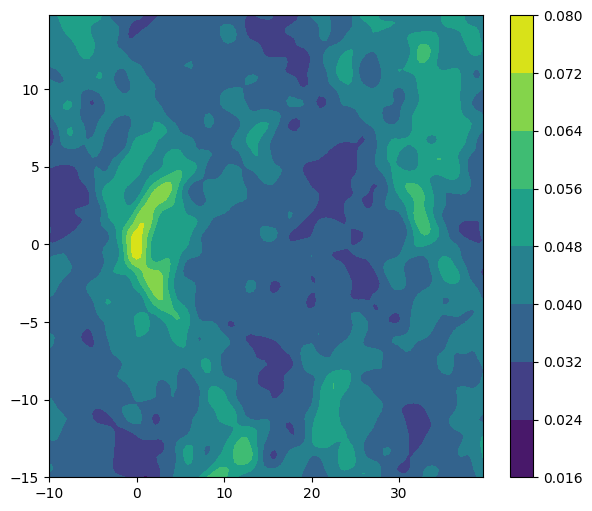

In [128]:
params = {
   'axes.labelsize': 12,
   'legend.fontsize': 12,
   'xtick.labelsize': 10,
   'ytick.labelsize': 10,
   'text.usetex': False,
   'figure.figsize': [7.0, 6.0]
   }
plt.rcParams.update(params)

print("max probability:", prob_expected_mixed.max())
print("min probability:",prob_expected_mixed.min())

print("log max probability:", np.log(prob_expected_mixed.max()))
print("log min probability:", np.log(prob_expected_mixed.min()))

plt.contourf(x, y, prob_expected_mixed.reshape([120,120]))
plt.colorbar()
plt.savefig("arcdmkde.pdf")

### Metrics

In [129]:
## K-L Divergence
from scipy.stats import entropy

# Compute KL Divergence
kl_divergence = entropy(raw_kde_probability, prob_expected_mixed)

print("KL Divergence:", kl_divergence)


KL Divergence: 2.4331020412872886


In [130]:
from scipy.stats import spearmanr

# Calculate the ranks of the density values
ranks1 = np.array(raw_kde_probability).argsort().argsort()
ranks2 = prob_expected_mixed.argsort().argsort()

# Calculate the Spearman correlation
spearman_corr, _ = spearmanr(ranks2, ranks1)

print("Spearman Correlation:", spearman_corr)

Spearman Correlation: 0.25245161495684615


In [131]:
# Calculate the absolute differences at each evaluation point
absolute_differences = np.abs(raw_kde_probability - prob_expected_mixed)

# Average the absolute differences
average_error = np.mean(absolute_differences)

print("Mean Average Error:", average_error)

Mean Average Error: 0.03989223131452955
